In [69]:
# ---------- Create Manifest with Train/Val/Test Split ----------
from pathlib import Path
import pandas as pd
import numpy as np


RAW_DIR = Path("C:/Users/daixi/Desktop/42177_Project/raw")
records = []


for img_path in RAW_DIR.rglob("*.*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        label = img_path.parent.name
        records.append({
            "filepath": str(img_path).replace("\\", "/"),
            "label": label
        })

# DataFrame
manifest = pd.DataFrame(records)
manifest.insert(0, "id", range(1, len(manifest) + 1))

# subset（70% train, 20% val, 10% test）
np.random.seed(42177)
manifest["subset"] = np.random.choice(["train", "val", "test"], size=len(manifest), p=[0.7, 0.2, 0.1])


manifest.to_csv("C:/Users/daixi/Desktop/42177_Project/manifest.csv", index=False)


print("Manifest created successfully.")
print(manifest["subset"].value_counts())


Manifest created successfully.
subset
train    23929
val       6904
test      3465
Name: count, dtype: int64


In [71]:
# ---------- CLEAN PREPROCESSING ----------
import os, json
from pathlib import Path
import numpy as np, pandas as pd
from tqdm import tqdm
from PIL import Image
from skimage import util, transform


from scipy.ndimage import convolve  

BASE_DIR = Path("C:/Users/daixi/Desktop/42177_Project")
RAW_DIR  = Path("C:/Users/daixi/Desktop/42177_Project/raw")
MANIFEST_SRC = Path("C:/Users/daixi/Desktop/42177_Project/manifest.csv")

OUT_CLEAN = BASE_DIR / "data" / "clean"
ART_DIR   = BASE_DIR / "artifacts"
for p in [OUT_CLEAN, ART_DIR]:
    p.mkdir(parents=True, exist_ok=True)


TARGET = (256, 256)
SEED = 42177
np.random.seed(SEED)

# ---------- Load MATLAB Manifest ----------
T = pd.read_csv(MANIFEST_SRC)
T["filepath"] = (
    T["filepath"].astype(str)
    .str.replace("\\", "/", regex=False)
    .str.replace("C:/Users/daixi/Desktop/42177_Project/raw", str(RAW_DIR), regex=False)
    .str.replace("/Toxoplasma400X/", "/Toxoplasma_400X_3758/", regex=False)
    .str.replace("/Toxoplasma1000X/", "/Toxoplasma_1000X_2933/", regex=False)
    .str.replace("/Babesia/", "/Babesia_1173/", regex=False)
    .str.replace("/Leishmania/", "/Leishmania_2701/", regex=False)
    .str.replace("/Plasmodium/", "/Plasmodium_843/", regex=False)
    .str.replace("/Trichomonad/", "/Trichomonad_10134/", regex=False)
    .str.replace("/Trypanosome/", "/Trypanosome_2385/", regex=False)
)

print(f"Loaded manifest with {len(T)} images and {T['label'].nunique()} labels.")

# ---------- Save preprocess params ----------
params = {"target_h":256,"target_w":256,"color_mode":"rgb","normalization":"im2double_0to1","seed":SEED}
with open(ART_DIR / "preproc_params.json", "w") as f:
    json.dump(params, f, indent=4)

# ---------- Generate CLEAN ----------
def preprocess_one(path, target):
    try:
        img = Image.open(path).convert("RGB").resize(target, Image.BILINEAR)
        return Image.fromarray((np.asarray(img)).astype(np.uint8))
    except Exception as e:
        print(f"Skip {path}: {e}")
        return None

print(f"Processing {len(T)} images for CLEAN dataset...")
for _, r in tqdm(T.iterrows(), total=len(T), dynamic_ncols=True, mininterval=2, leave=False):
    sub, lab, pid = r["subset"], r["label"], r["id"]
    path = r["filepath"]
    outd = OUT_CLEAN / sub / lab
    outd.mkdir(parents=True, exist_ok=True)
    img = preprocess_one(path, TARGET)
    if img:
        img.save(outd / f"img_{pid:07d}.png")
print("Clean preprocessing complete.")


Loaded manifest with 34298 images and 10 labels.
Processing 34298 images for CLEAN dataset...


Clean preprocessing complete.


In [73]:
# ---------- DEGRADED GENERATION ----------
import os
from pathlib import Path
import numpy as np, pandas as pd
from tqdm import tqdm
from PIL import Image, ImageFilter
from skimage import util, transform
from scipy.ndimage import convolve

BASE_DIR = Path("C:/Users/daixi/Desktop/42177_Project")
OUT_CLEAN = BASE_DIR / "data" / "clean"
OUT_DEG   = BASE_DIR / "data" / "degraded"
for p in [OUT_DEG]:
    p.mkdir(parents=True, exist_ok=True)

MANIFEST_SRC = Path("C:/Users/daixi/Desktop/42177_Project/manifest.csv")

T = pd.read_csv(MANIFEST_SRC)
deg = T[T["subset"].isin(["val", "test"])]
print(f"Generating degradations for {len(deg)} images...")

levels = {
    "resolution": [2, 4],
    "gaussian_blur": [1.0, 2.0],
    "motion_blur": [5],
    "gaussian_noise": [5, 15],
    "jpeg": [60, 40, 20]
}

for _, r in tqdm(deg.iterrows(), total=len(deg), dynamic_ncols=True, mininterval=2, leave=False):
    pid, sub, lab = r["id"], r["subset"], r["label"]
    clean_path = OUT_CLEAN / sub / lab / f"img_{pid:07d}.png"
    if not clean_path.exists(): 
        continue
    img = Image.open(clean_path).convert("RGB")
    arr = np.asarray(img) / 255.0
    h, w = arr.shape[:2]

    # 1. Resolution
    for f in levels["resolution"]:
        small = transform.resize(arr, (h//f, w//f), order=1, anti_aliasing=True)
        up = transform.resize(small, (h, w), order=1, anti_aliasing=True)
        outd = OUT_DEG / f"resolution_x{f}" / sub / lab
        outd.mkdir(parents=True, exist_ok=True)
        Image.fromarray((up*255).astype(np.uint8)).save(outd / f"img_{pid:07d}.png")

    # 2. Gaussian blur
    for s in levels["gaussian_blur"]:
        outd = OUT_DEG / f"gaussian_blur_s{s}" / sub / lab
        outd.mkdir(parents=True, exist_ok=True)
        img.filter(ImageFilter.GaussianBlur(s)).save(outd / f"img_{pid:07d}.png")

    # 3. Motion blur
    for k in levels["motion_blur"]:
        kernel = np.zeros((k,k)); kernel[k//2,:] = 1/k
        J = np.copy(arr)
        for c in range(3):
            J[..., c] = convolve(arr[..., c], kernel, mode="reflect")
        outd = OUT_DEG / f"motion_blur_k{k}" / sub / lab
        outd.mkdir(parents=True, exist_ok=True)
        Image.fromarray((J*255).astype(np.uint8)).save(outd / f"img_{pid:07d}.png")

    # 4. Gaussian noise
    for s in levels["gaussian_noise"]:
        J = util.random_noise(arr, mode="gaussian", var=(s/255)**2)
        outd = OUT_DEG / f"gaussian_noise_s{s}" / sub / lab
        outd.mkdir(parents=True, exist_ok=True)
        Image.fromarray((J*255).astype(np.uint8)).save(outd / f"img_{pid:07d}.png")

    # 5. JPEG compression
    for q in levels["jpeg"]:
        outd = OUT_DEG / f"jpeg_q{q}" / sub / lab
        outd.mkdir(parents=True, exist_ok=True)
        img.save(outd / f"img_{pid:07d}.jpg", quality=q)

print("Degraded dataset generation complete.")


Generating degradations for 10369 images...


Degraded dataset generation complete.


In [3]:
!pip install opencv-python scikit-learn xgboost matplotlib tqdm joblib pandas numpy

  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


In [39]:
# =========================================
# Module 1: Import Libraries and Define Paths
# =========================================

import os, cv2, joblib, numpy as np, pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---- Define project base paths ----
BASE_DIR = Path("C:/Users/daixi/Desktop/42177_Project")  
CLEAN_DIR = BASE_DIR / "data" / "clean"                  
DEGRADED_DIR = BASE_DIR / "data" / "degraded"            
MODEL_DIR = BASE_DIR / "models"                          
for p in [MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ---- Global constants ----
IMG_SIZE = (48, 48)          
SEED = 42177                 
np.random.seed(SEED)

print("Module 1 completed: libraries imported and paths defined.")



# =========================================
# Module 2: Define Helper Function
# =========================================

def load_dataset(data_dir):
    """
    Load all images recursively from clean/train, clean/val, clean/test folders.
    Returns X (flattened image array), y (class index), labels (class names).
    """
    X, y = [], []
    data_dir = Path(data_dir)

  
    all_labels = sorted({p.name for p in data_dir.rglob("*") if p.is_dir() and len(list(p.glob("*.*"))) > 0})
    label_map = {label: idx for idx, label in enumerate(all_labels)}

    for label in all_labels:
        for img_path in data_dir.rglob(f"{label}/*.*"):
            if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                continue
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (48, 48))
            X.append(gray.flatten())
            y.append(label_map[label])

    X = np.array(X)
    y = np.array(y)
    return X, y, all_labels


print("Module 2 completed: helper function defined.")

# =========================================
# Module 3 (Revised): Load and Preprocess CLEAN Dataset (by manifest)
# =========================================
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---------- Paths ----------
BASE_DIR = Path(r"C:/Users/daixi/Desktop/42177_Project")
CLEAN_DIR = BASE_DIR / "data" / "clean"
MANIFEST_PATH = BASE_DIR / "manifest.csv"
SEED = 42177
IMG_SIZE = (48, 48)

# ---------- Helper Function ----------
def load_from_manifest(manifest_csv, clean_dir):
    """
    Load dataset strictly following the manifest file.
    This ensures the sample count matches the manifest (≈34k images).
    """
    T = pd.read_csv(manifest_csv)
    X, y = [], []
    labels = sorted(T["label"].unique().tolist())
    label_to_idx = {lab: i for i, lab in enumerate(labels)}

    for _, row in T.iterrows():
        pid = int(row["id"])
        sub = row["subset"]
        lab = row["label"]
        path = clean_dir / sub / lab / f"img_{pid:07d}.png"

        if not path.exists():
            continue

        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, IMG_SIZE)
        X.append(img.flatten())
        y.append(label_to_idx[lab])

    X = np.array(X)
    y = np.array(y)
    return X, y, labels


# ---------- Main Loading Process ----------
print("Loading CLEAN dataset strictly according to manifest...")
X, y, labels = load_from_manifest(MANIFEST_PATH, CLEAN_DIR)
print(f"Loaded {len(X)} images from {len(labels)} classes.")

# ---------- Feature Standardization ----------
print("Standardizing features...")
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# ---------- Split into Training and Testing Sets ----------
print("Splitting dataset into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Data ready: {len(X_train)} train samples, {len(X_test)} test samples.")
print("Module 3 completed successfully (data count consistent with manifest).")


Module 1 completed: libraries imported and paths defined.
Module 2 completed: helper function defined.
Loading CLEAN dataset strictly according to manifest...
Loaded 34298 images from 10 classes.
Standardizing features...
Splitting dataset into training and test sets...
Data ready: 27438 train samples, 6860 test samples.
Module 3 completed successfully (data count consistent with manifest).


=== Training AdaBoost Classifier ===
AdaBoost Accuracy: 62.35%
AdaBoost Macro-F1: 23.93%

Classification Report:
                       precision    recall  f1-score   support

         Babesia_1173       0.00      0.00      0.00       235
      Leishmania_2701       0.00      0.00      0.00       540
  Leukocyte_1000X_461       0.00      0.00      0.00        92
   Leukocyte_400X_915       1.00      0.07      0.12       183
       Plasmodium_843       0.00      0.00      0.00       168
            RBCs_8995       0.50      0.91      0.65      1799
Toxoplasma_1000X_2933       0.00      0.00      0.00       587
 Toxoplasma_400X_3758       0.77      0.80      0.78       752
    Trichomonad_10134       0.73      1.00      0.84      2027
     Trypanosome_2385       0.00      0.00      0.00       477

             accuracy                           0.62      6860
            macro avg       0.30      0.28      0.24      6860
         weighted avg       0.46      0.62      0.51      6860



C:\Users\daixi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\daixi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\daixi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


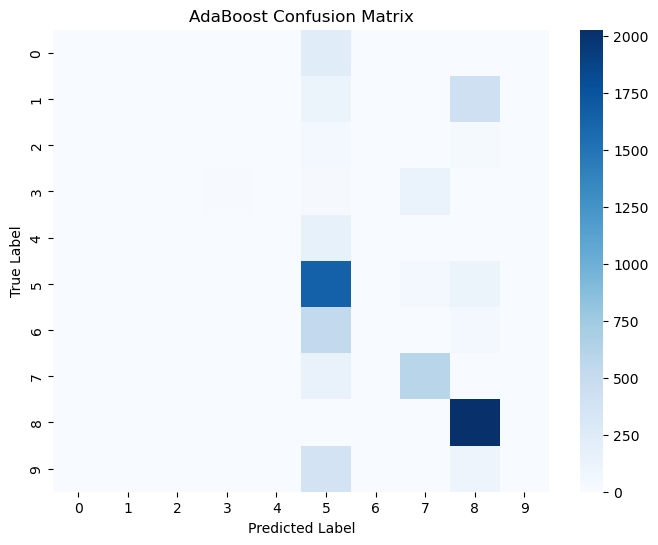

AdaBoost model saved successfully.



In [43]:
# =========================================
# Module 4A: Train and Evaluate AdaBoost Classifier (Final Version)
# =========================================
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("=== Training AdaBoost Classifier ===")

# --- Base learner (Decision Stump: a tree with only one split) ---
base_tree = DecisionTreeClassifier(max_depth=1, random_state=SEED)

# --- AdaBoost model (explicitly specify SAMME to avoid warning) ---
ada = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=200,          # number of weak learners
    learning_rate=0.1,         # step size
    algorithm='SAMME',         # explicitly set SAMME to avoid deprecation warning
    random_state=SEED
)

# --- Train model ---
ada.fit(X_train, y_train)

# --- Predict on test set ---
y_pred_ada = ada.predict(X_test)

# --- Evaluate performance ---
acc_ada = accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada, average='macro')

print(f"AdaBoost Accuracy: {acc_ada*100:.2f}%")
print(f"AdaBoost Macro-F1: {f1_ada*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ada, target_names=labels))

# --- Confusion Matrix Visualization ---
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ada, annot=False, cmap="Blues")
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- Save trained model ---
joblib.dump(ada, BASE_DIR / "adaboost_model.pkl")
print("AdaBoost model saved successfully.\n")


=== Training XGBoost Classifier ===
XGBoost Accuracy: 94.64%
XGBoost Macro-F1: 90.36%

Classification Report:
                       precision    recall  f1-score   support

         Babesia_1173       0.95      0.82      0.88       235
      Leishmania_2701       0.87      0.86      0.86       540
  Leukocyte_1000X_461       0.99      0.83      0.90        92
   Leukocyte_400X_915       0.99      0.97      0.98       183
       Plasmodium_843       0.88      0.54      0.67       168
            RBCs_8995       0.94      0.99      0.96      1799
Toxoplasma_1000X_2933       0.93      0.95      0.94       587
 Toxoplasma_400X_3758       0.99      0.99      0.99       752
    Trichomonad_10134       0.97      0.99      0.98      2027
     Trypanosome_2385       0.92      0.83      0.87       477

             accuracy                           0.95      6860
            macro avg       0.94      0.88      0.90      6860
         weighted avg       0.95      0.95      0.94      6860



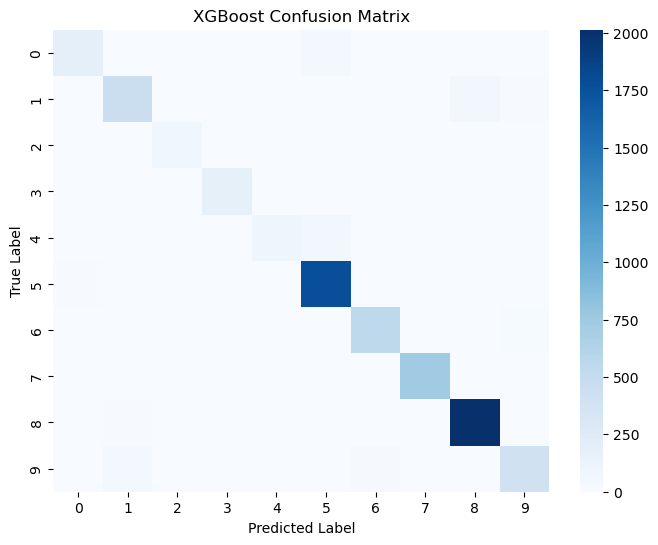

XGBoost model saved successfully.


In [49]:
# =========================================
# Module 4B: Train and Evaluate XGBoost Classifier
# =========================================

print("=== Training XGBoost Classifier ===")

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---- Train XGBoost ----
xgb_model = XGBClassifier(
    n_estimators=300,         # number of boosting rounds
    learning_rate=0.1,        # shrinkage step size
    max_depth=5,              # depth of trees (controls complexity)
    subsample=0.8,            # fraction of samples for each tree
    colsample_bytree=0.8,     # fraction of features for each tree
    random_state=SEED,
    objective='multi:softmax', # multiclass classification
    num_class=len(set(y_train))
)

xgb_model.fit(X_train, y_train)

# ---- Evaluate XGBoost ----
y_pred_xgb = xgb_model.predict(X_test)

acc_xgb = (y_pred_xgb == y_test).mean() * 100
print(f"XGBoost Accuracy: {acc_xgb:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=labels))

# ---- Confusion Matrix ----
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, cmap="Blues", annot=False)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ---- Save Model ----
joblib.dump(xgb_model, BASE_DIR / "artifacts" / "xgboost_model.pkl")
print("XGBoost model saved successfully.")


 Models and scaler saved successfully.

=== Model Performance Summary ===
AdaBoost  →  Accuracy: 62.35%,  Macro-F1: 23.93%
XGBoost   →  Accuracy: 94.64%,  Macro-F1: 90.36%

 XGBoost outperformed AdaBoost in both accuracy and F1-score.


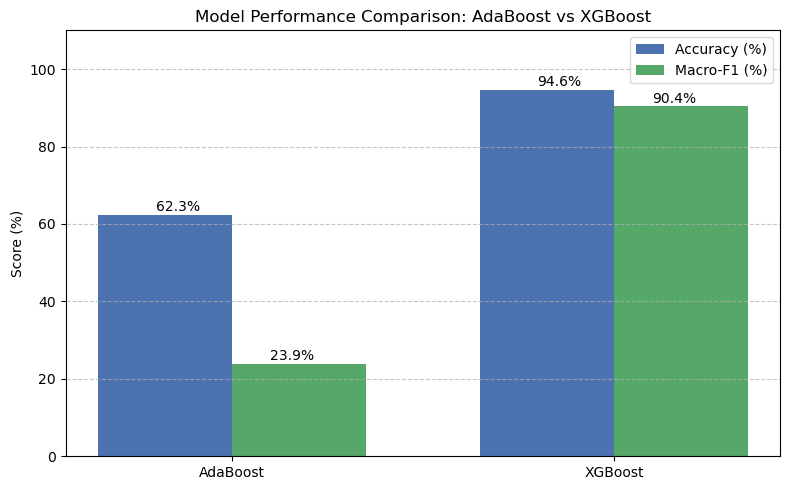

 Performance comparison plot saved as model_performance_comparison.png.



In [62]:
# =========================================
# Module 5: Save Models and Compare Performance
# =========================================

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import f1_score

# ---- 1. Create model save directory ----
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---- 2. Save trained models and scaler ----
# Use consistent variable names from Module 4A and 4B
joblib.dump(ada, MODEL_DIR / "adaboost_model.pkl")
joblib.dump(xgb_model, MODEL_DIR / "xgboost_model.pkl")  # ✅ 改这里
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
print(" Models and scaler saved successfully.\n")

# ---- 3. Compute performance metrics ----
ada_acc = (y_pred_ada == y_test).mean() * 100
ada_f1 = f1_score(y_test, y_pred_ada, average='macro') * 100

xgb_acc = (y_pred_xgb == y_test).mean() * 100
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro') * 100

# ---- 4. Print comparison summary ----
print("=== Model Performance Summary ===")
print(f"AdaBoost  →  Accuracy: {ada_acc:.2f}%,  Macro-F1: {ada_f1:.2f}%")
print(f"XGBoost   →  Accuracy: {xgb_acc:.2f}%,  Macro-F1: {xgb_f1:.2f}%")

if xgb_acc > ada_acc:
    print("\n XGBoost outperformed AdaBoost in both accuracy and F1-score.")
else:
    print("\n AdaBoost performed better or comparably. Check class balance or hyperparameters.\n")

# ---- 5. Visualise performance comparison ----
models = ['AdaBoost', 'XGBoost']
accuracy_scores = [ada_acc, xgb_acc]
f1_scores = [ada_f1, xgb_f1]

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, accuracy_scores, bar_width, label='Accuracy (%)', color='#4C72B0')
plt.bar(x + bar_width/2, f1_scores, bar_width, label='Macro-F1 (%)', color='#55A868')

# ---- Annotate scores on top of bars ----
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    plt.text(i - 0.2, acc + 1, f"{acc:.1f}%", fontsize=10)
    plt.text(i + 0.1, f1 + 1, f"{f1:.1f}%", fontsize=10)

plt.xticks(x, models)
plt.ylim(0, 110)
plt.ylabel('Score (%)')
plt.title('Model Performance Comparison: AdaBoost vs XGBoost')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# ---- 6. Save figure ----
plt.savefig(BASE_DIR / "model_performance_comparison.png", dpi=300)
plt.show()
print(" Performance comparison plot saved as model_performance_comparison.png.\n")


=== Evaluating Model Robustness on Degraded Datasets ===
gaussian_blur_s1.0        Accuracy: 98.90%
gaussian_blur_s2.0        Accuracy: 98.61%
gaussian_noise_s15        Accuracy: 92.29%
gaussian_noise_s5         Accuracy: 98.47%
jpeg_q20                  Accuracy: 98.15%
jpeg_q40                  Accuracy: 98.56%
jpeg_q60                  Accuracy: 98.67%
motion_blur_k5            Accuracy: 98.87%
resolution_x2             Accuracy: 98.82%
resolution_x4             Accuracy: 98.59%

=== Summary of Model Robustness ===


,Degradation,Accuracy (%)
0,gaussian_blur_s1.0,98.903319
1,gaussian_blur_s2.0,98.614719
2,gaussian_noise_s15,92.294372
3,gaussian_noise_s5,98.470418
4,jpeg_q20,98.152958
5,jpeg_q40,98.556999
6,jpeg_q60,98.672439
7,motion_blur_k5,98.874459
8,resolution_x2,98.816739
9,resolution_x4,98.585859



 Robustness evaluation completed successfully.
Results saved as model_robustness_results.png and model_robustness_summary.csv.


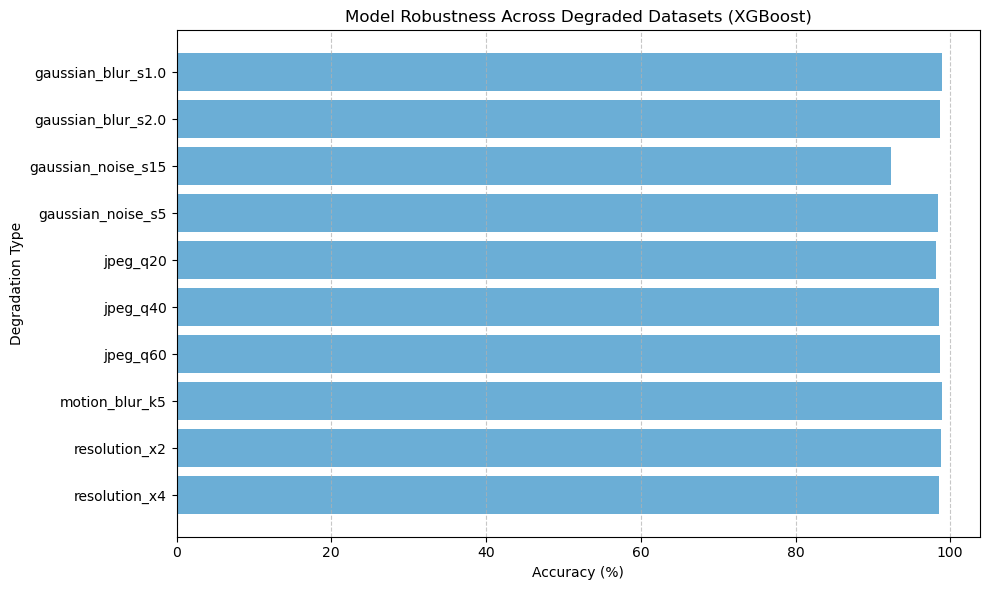

In [76]:
# =========================================
# Module 6: Evaluate Model Robustness on Degraded Datasets (Final Version)
# =========================================
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from joblib import load
import matplotlib.pyplot as plt

print("=== Evaluating Model Robustness on Degraded Datasets ===")

# ---- 1. Load trained model and scaler ----
MODEL_DIR = BASE_DIR / "models"
xgb_model = load(MODEL_DIR / "xgboost_model.pkl")
scaler = load(MODEL_DIR / "scaler.pkl")

# ---- 2. Define degraded dataset directory ----
DEG_DIR = BASE_DIR / "data" / "degraded"
robustness_results = []

# ---- 3. Evaluate model on each degraded test set ----
for d in sorted(os.listdir(DEG_DIR)):
    test_path = os.path.join(DEG_DIR, d, "test")
    if not os.path.isdir(test_path):
        continue  # skip folders without test set

    print(f"{d:<25}", end=" ")

    # Load degraded dataset
    X_deg, y_deg, _ = load_dataset(test_path)

    # Convert labels to integer type (same encoding as training data)
    y_deg = np.array(y_deg, dtype=int)

    # Skip if no data found
    if len(X_deg) == 0:
        print("→ No images found, skipped.")
        continue

    # Standardize features
    X_deg_scaled = scaler.transform(X_deg)

    # Predict on degraded test set
    y_pred_deg = xgb_model.predict(X_deg_scaled)

    # Compute accuracy
    acc = accuracy_score(y_deg, y_pred_deg) * 100
    robustness_results.append((d, acc))
    print(f"Accuracy: {acc:.2f}%")

# ---- 4. Summarize results ----
print("\n=== Summary of Model Robustness ===")
robustness_df = pd.DataFrame(robustness_results, columns=["Degradation", "Accuracy (%)"])
display(robustness_df)

# ---- 5. Plot robustness chart ----
plt.figure(figsize=(10, 6))
plt.barh(robustness_df["Degradation"], robustness_df["Accuracy (%)"], color="#6BAED6")
plt.xlabel("Accuracy (%)")
plt.ylabel("Degradation Type")
plt.title("Model Robustness Across Degraded Datasets (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# ---- 6. Save results ----
plt.savefig(BASE_DIR / "model_robustness_results.png", dpi=300)
robustness_df.to_csv(BASE_DIR / "model_robustness_summary.csv", index=False)

print("\n Robustness evaluation completed successfully.")
print("Results saved as model_robustness_results.png and model_robustness_summary.csv.")
